# Predicting the Severity of Power Outages in the US

## Summary of Findings


### Introduction
The dataset records all power outages that happened from year 2000 to year 2016 within the United States. It contains information related to the power outage (cause, duration and extent of event) as well as characteristics of the region where the event took place (climate condition, climate region, regional electricity consumption, economic characteristics and land-use characteristics).

##### Model type
In this project, we will build a **multiple linear regression model to predict the number of customer affected after a major power outage.** This model will be useful in providing local authorities an initial estimate of the damage (in terms of the number of customers affected) of a power outage event. This would further help them to gauge the number of incoming complaints, or even worse, the loss of customers.

##### Model evaluation
For model evaluation, we will primarily use **R-squared value** as we would like to observe **the ability of our response variables in explaining the variation of the number of customers affected**. If we have a low R-squared value, we will have to **consider more complex features in our model such as interaction terms and square-root transformation (in case of heteroskedasticity).**

##### Model features
Our model generates prediction **right after** a power outage event. That said, our model would **prioritize the duration of outage (_'OUTAGE.DURATION'_) in making predictions (more in Final Model section)**. We would also have access to the following regional information: 
1. State (where the event occured, also denoted as _'U.S._STATE'_)
2. State population (_'POPULATION'_)
3. Time (when the event occured, also denoted as _'TIME_IN_DAY'_)
4. NERC region (defined by The North American Electric Reliability Corporation (NERC), also denoted as _'NERC.REGION'_)
5. Climate region (defined by the National Centers for Environmental Information, also denoted as _'CLIMATE.REGION'_)
6. Cause category (the cause of outage that was identified during restoration, also denoted as _'CAUSE.CATEGORY'_)
7. (Only in Final Model) Urban population density of the state (_'POPDEN_URBAN'_)

From the above, information 1 and 3 are available at the start of a power outage, information 6 will be available during the restoration of power and information 2, 4, 5, 7 are factual information about a state.



Based on the given dataset, information about total electricity consumption and total number of customers would be useful. However, we may not have information about the total electricity consumption and total customers at the point of outage, since they are generated on a yearly basis - most likely the end of every year. 

In the code below, we explored the possibility of replicating data about electricity consumption and total customers based on the previous year data. However, we found that the past data about total customers was incomplete as major power outages do not take place every single year. For example, in Alabama, power outages happened only in year 2000, 2013, 2014, and 2015 (we will explore another method in our Final Model). Similarly, we found that there is a large variation in total electricity consumption (denoted as total sales in our code below) and we could not simply use the previous year sales because the percentage change (growth) in sales is large.

### Baseline Model

##### Model features and preprocessing steps
To begin with, we used a Linear Regression model as our baseline model. The features that we used in our baseline model, as well as the preprocessing steps we performed are as follows:

Categorical (nominal) data which we performed One Hot Encoding using sklearn:
1. State (_'U.S._STATE'_) 
2. Time (_'TIME_IN_DAY'_)
3. NERC region (_'NERC.REGION'_)
4. Climate region (_'CLIMATE.REGION'_)
5. Cause category (_'CAUSE.CATEGORY'_)

Quantitative data (kept as-is):
1. State population (_'POPULATION'_)
2. Outage duration (_'OUTAGE.DURATION'_)

There was a total of 2 quantitative columns and 5 nominal columns. We used sklearn ColumnTransformer for feature engineering and together with a pipeline, a Linear Regression model was created.

The original dataset was splitted into training data (80%) and testing data (20%) using sklearn's train_test_split. Using our training data, we conducted cross validation using KFold. 

##### Cross validation
We obtained two scores - mean RMSE (251872) and mean R-squared (-0.00502). The average RMSE tells us that the on average the average deviation of the predicted value from the actual value is around 251872 customers. The negative mean R-squared value suggests that the model fits worse than a horizontal line - which is bad.

##### Test data and training data score
There was a positive (yet low) R-squared for our test data (0.011) and a higher R-squared (0.218) for our training data. The R-squared for our test data was close to 0, indicating that almost none of our variables explain the variation of the number of customers affected. The difference in the R-squared value between our test data and training data suggests that the model is overfitting to our training data.

### Final Model

##### Summary
Overall, we explored 3 different types of Regression model:
1. Linear Regression
2. Ridge Regression (useful when variables are highly correlated)
3. SGD Regression (with customized loss function)

For each of the model, we used the same features (with the same feature engineering method) as well as the same training and testing data for consistency.

In Ridge Regression and SGD Regression, we conducted a simple GridSearchCV to identify the best hyperparameters for the two models.

##### Newly added model features
1. Interaction terms (multiplication of two quantitative columns)
Here, we explored the relationship of regional land-use information (population, population density, and contribution of utility industry) with outage duration. The idea is that: the marginal effect of, say, population on the number of customers affected may not be constant. 

In our analysis, we found that interaction terms showed much obvious correlation with the number of customers affected. For example, when holding the population variable constant, its marginal effect on the number of customers affected increases as outage duration inceases. Having plotted a few scatterplots, we decided to use the interaction term for population & duration and urban population density & duration.

2. Predicted total number of customers (like a nested linear regression model)
We found that there is a strong correlation between the state population and the actual number of customers. We created a function that takes population data, predicts the total number of customers, and then returns the interaction term for predicted total number of customers and outage duration (which is also number of customers * outage duration). This was then passed to a FunctionTransformer,

3. Square-root transformation of y-value
As we were observing the usefulness of interaction terms, we also found that there was heteroskedasticity in some of the plots that showed the number of customers affected v.s. interaction terms. That said, we decided to transform the "CUSTOMERS.AFFECTED" column, which means that the predicted value of our model should be squared to get the number of customers affected in real terms.

##### Dropped features
1. Time in day when the outage occured
We found that the feature "TIME_IN_DAY" was less useful for our model.

##### Result
**Linear Regression**
1. Mean R-squared of CV: 0.36
2. R-squared of training data: 0.45
3. R-squared of testing data: 0.37

We chose linear regression model as our final model given that it has the highest R2 value for our validation data, test data and training data amongst all three models

### Fairness Analysis
We would like to investigate our model generates fair result regardless of the population of the state. If our model is unfair in a way that it always predicts, say, greater severity or in general works better in much populated states, it may lead to unfair distribution of resources, as well as unreliable source of information.

**Null Hypothesis**: Our final linear regression model is fair - R2 values for states with high population and mid-low population are roughly the same, and any differences are due to random chance.

**Alternative Hypothesis**: Our model is unfair - R2 for highly populated states is lower than mid-low population states.

We will run the permutation test at 99% confidence level

Our p-value was 0.078. Since our p-value is greater than 0.01, we will not reject the null hypothesis. There is insufficient evidence to conclude that our model is unfair.

## Code

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

## Cleaned data from Project 3

In [301]:
#get data
df_ori = pd.read_csv('outage.csv')

#drop OBS (observation) column
df = df_ori.drop(columns='OBS')

#combining start date & time and restoration date & time
df['OUTAGE.START.DATE.TIME'] = pd.to_datetime(df['OUTAGE.START.DATE'] + ", " + df['OUTAGE.START.TIME'])
df['OUTAGE.RESTORATION.DATE.TIME'] = pd.to_datetime(df['OUTAGE.RESTORATION.DATE'] + ", " + df['OUTAGE.RESTORATION.TIME'])

#dropping original columns of start date & time and restoration date & time
df = df.drop(columns=['OUTAGE.START.DATE','OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])

#there's a false input in NERC.REGION
df.loc[:, 'NERC.REGION'].replace('FRCC, SERC', 'FRCC', inplace=True)

#adding a "Major Outage" column to identify major outages (affected over 50,000 customers or over 300MW of demand loss)
df['MAJOR.OUTAGE'] = (df['CUSTOMERS.AFFECTED'] >= 50_000) | (df['DEMAND.LOSS.MW'] >= 300)

#adding categorical variables for time in a day
time_in_day = {
    0:'midnight',
    1:'midnight',
    2:'midnight',
    3:'early morning',
    4:'early morning',
    5:'early morning',
    6:'morning',
    7:'morning',
    8:'morning',
    9:'late morning',
    10:'late morning',
    11:'late morning',
    12:'early afternoon',
    13:'early afternoon',
    14:'early afternoon',
    15:'early afternoon',
    16:'late afternoon',
    17:'late afternoon',
    18:'late afternoon',
    19:'evening',
    20:'evening',
    21:'evening',
    22:'night',
    23:'night'
}
df['TIME_IN_DAY'] = df['OUTAGE.START.DATE.TIME'].dt.hour.map(time_in_day)

## Framing the Problem

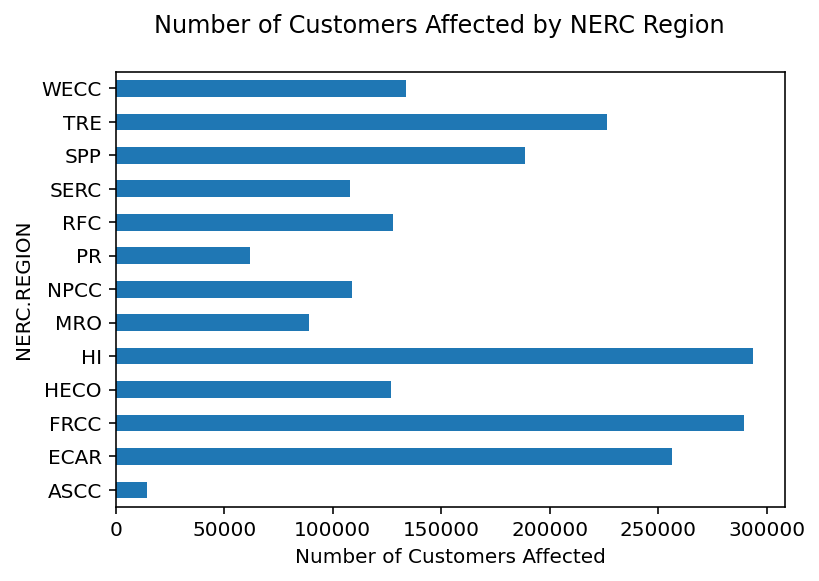

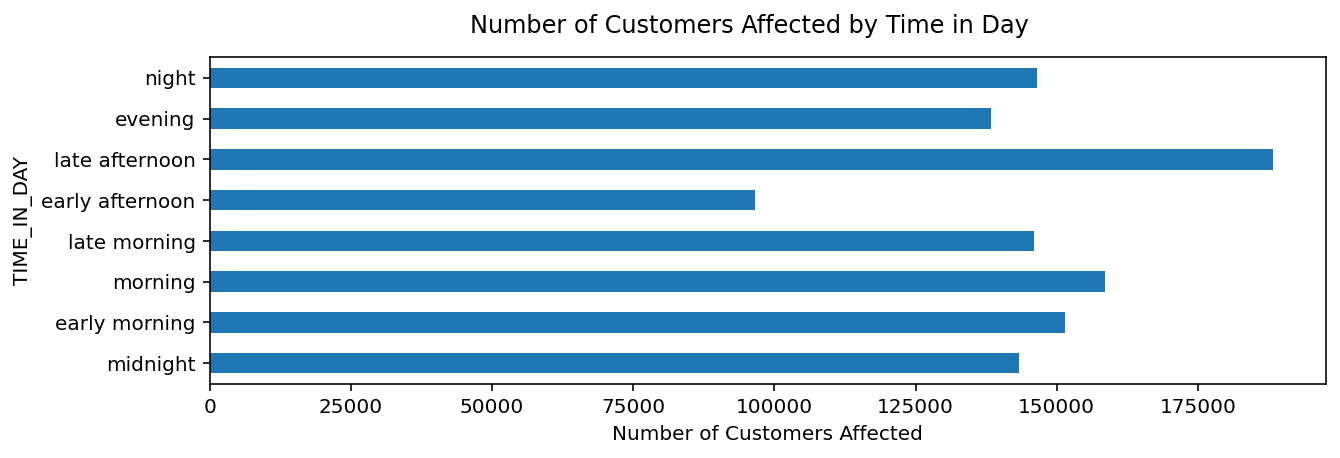

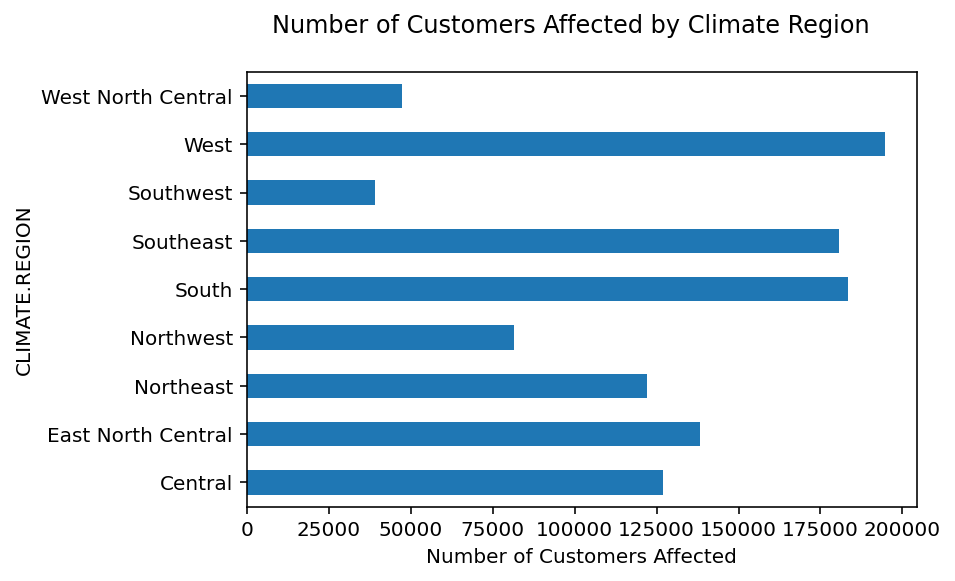

In [606]:
p1 = plt.figure(1)
df.groupby('NERC.REGION')['CUSTOMERS.AFFECTED'].mean().plot.barh()
plt.xlabel('Number of Customers Affected')
p1.suptitle('Number of Customers Affected by NERC Region')

p2 = plt.figure(2, figsize=(10, 3)) 
order=['midnight', 'early morning', 'morning', 'late morning', 'early afternoon', 'late afternoon', 'evening', 'night']
df.groupby('TIME_IN_DAY')['CUSTOMERS.AFFECTED'].mean().loc[order].plot.barh()
plt.xlabel('Number of Customers Affected')
p2.suptitle('Number of Customers Affected by Time in Day')

p3 = plt.figure(3)
df.groupby('CLIMATE.REGION')['CUSTOMERS.AFFECTED'].mean().plot.barh()
plt.xlabel('Number of Customers Affected')
p3.suptitle('Number of Customers Affected by Climate Region')

plt.show()

From the barplots above, we can roughly observed the influence of categorical data on the number of customers affected. For example, West, Southeast and South climate regions tend to have higher number of customers affected.

In [304]:
customers_year_state = df.groupby(['U.S._STATE', 'YEAR'], as_index=False)['TOTAL.CUSTOMERS'].mean()
diff_year_state = customers_year_state.groupby(['U.S._STATE']).diff(axis=0)
customers_year_state['AVG_YEARLY_CHANGE'] = diff_year_state['TOTAL.CUSTOMERS']/diff_year_state['YEAR']
customers_year_state['PERCENT_CHANGE'] = customers_year_state['AVG_YEARLY_CHANGE']/(customers_year_state['TOTAL.CUSTOMERS']-customers_year_state['AVG_YEARLY_CHANGE'])*100
customers_year_state.groupby(['U.S._STATE'])['PERCENT_CHANGE'].agg(['min','max']).sort_values(by=['max', 'min'], ascending=False).head()

,min,max
U.S._STATE,,
New York,-4.384322,12.636011
California,-0.251450,7.919839
Arizona,0.645084,4.099129
Texas,-0.358781,3.605045
Kansas,-0.645308,2.728900


In [305]:
sales_year_state = df.groupby(['U.S._STATE', 'YEAR'], as_index=False)['TOTAL.SALES'].mean()
sales_diff_year_state = sales_year_state.groupby(['U.S._STATE']).diff(axis=0)
sales_year_state['AVG_YEARLY_CHANGE'] = sales_diff_year_state['TOTAL.SALES']/sales_diff_year_state['YEAR']
sales_year_state['PERCENT_CHANGE'] = sales_year_state['AVG_YEARLY_CHANGE']/(sales_year_state['TOTAL.SALES']-sales_year_state['AVG_YEARLY_CHANGE'])*100
sales_year_state.groupby(['U.S._STATE'])['PERCENT_CHANGE'].agg(['min','max']).sort_values(by=['max', 'min'], ascending=False).head()

,min,max
U.S._STATE,,
Arizona,-21.098114,63.295117
Florida,-18.903504,37.372043
Oklahoma,-28.777165,37.213659
Nevada,-14.170181,36.355732
Maryland,-28.624637,28.971555


Text(0.5, 0.98, 'Scatterplot of Number of Customers AffectedOutage Duration')

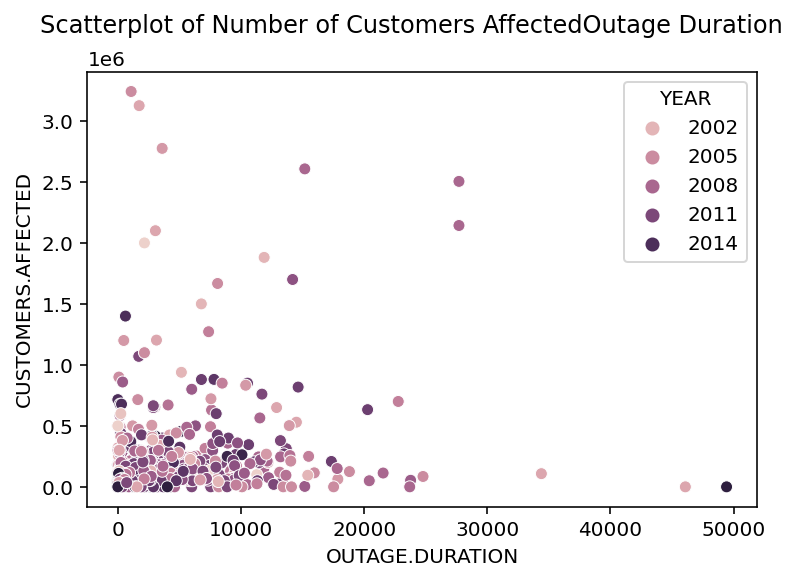

In [632]:
# check if year has an impact on the outage duration and customers affected 
# (perhaps due to better mitigation strategies/ technologies over time)
sns.scatterplot(data=df, x='OUTAGE.DURATION', y='CUSTOMERS.AFFECTED', hue='YEAR')
plt.suptitle('Scatterplot of Number of Customers AffectedOutage Duration')

There seem to be a slight correlation between outage duration and customers affected. We shall explore more in our baseline model

### Baseline Model

In [461]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [469]:
# look at the following columns: ['OUTAGE.DURATION', 'NERC.REGION', 'CLIMATE.REGION', 'POPULATION', 'TIME_IN_DAY', 'CAUSE.CATEGORY']
df_dropna = df[['OUTAGE.DURATION', 'U.S._STATE','NERC.REGION', 'CLIMATE.REGION', 'POPULATION', 'TIME_IN_DAY', 'CUSTOMERS.AFFECTED', 'CAUSE.CATEGORY']].dropna()
X = df_dropna[['OUTAGE.DURATION', 'U.S._STATE','NERC.REGION', 'CLIMATE.REGION', 'POPULATION', 'TIME_IN_DAY', 'CAUSE.CATEGORY']]
y = df_dropna['CUSTOMERS.AFFECTED']

# Split our dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Column Transformer 
feature_eng = ColumnTransformer([
    ('ohe', Pipeline([('ohe', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))]), \
     ['U.S._STATE', 'NERC.REGION', 'TIME_IN_DAY', 'CLIMATE.REGION','CAUSE.CATEGORY'])
], remainder='passthrough')

# Pipeline with Linear Regression
pl_base = Pipeline([
    ('cat_ohe', feature_eng),
    ('lin_reg', LinearRegression())
])

After splitting dataset and creating pipeline, we will now run our model.

In [524]:
# perform KFold cross validation to check R2 and RMSE of our validation test
folds = KFold(n_splits = 5, shuffle=True) # shuffle before doing cross validation
r2_val_scores = cross_val_score(pl_base, X_train, y_train, scoring='r2', cv=folds)
rmse_val_scores = -1*cross_val_score(pl_base, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print('Mean R2 of CV: ', r2_val_scores.mean())
print('Mean RMSE of CV: ', rmse_val_scores.mean())

Mean R2 of CV:  -0.005023685325392014
Mean RMSE of CV:  251872.36169331512


The average RMSE tells us that the on average the average deviation of the predicted value from the actual value is around 251872 customers. The negative mean R2 value suggests that the model fits worse than a horizontal line - which is bad.

In [550]:
# now, let's fit our model
pl_base.fit(X_train, y_train)

# here, we will compute the R2 for both the testing data and training data (as a whole)
print('R2 of Test Data: ', pl_base.score(X_test, y_test))
print('R2 of Training Data: ', pl_base.score(X_train, y_train))

R2 of Test Data:  0.011526896023634436
R2 of Training Data:  0.21847708471545524


Despite the negative mean R2 in our cross validation analysis, the model has a positive (yet low) R2 with our test data and a higher R2 with our training data. This also suggests overfitting with training data.

### Final Model

Let's start with finding some **potential new features by considering interaction terms**. We will explore the relationship of regional land-use information (population, population density, and contribution of utility industry) with outage duration. 

The idea here is that, the longer the outage duration, the marginal effect of population (for example) on the number of customers affected may increase

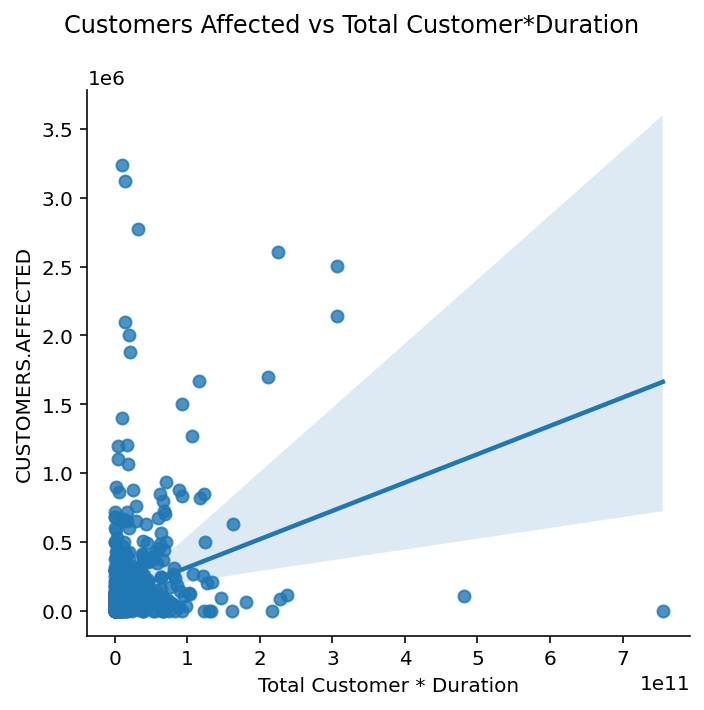

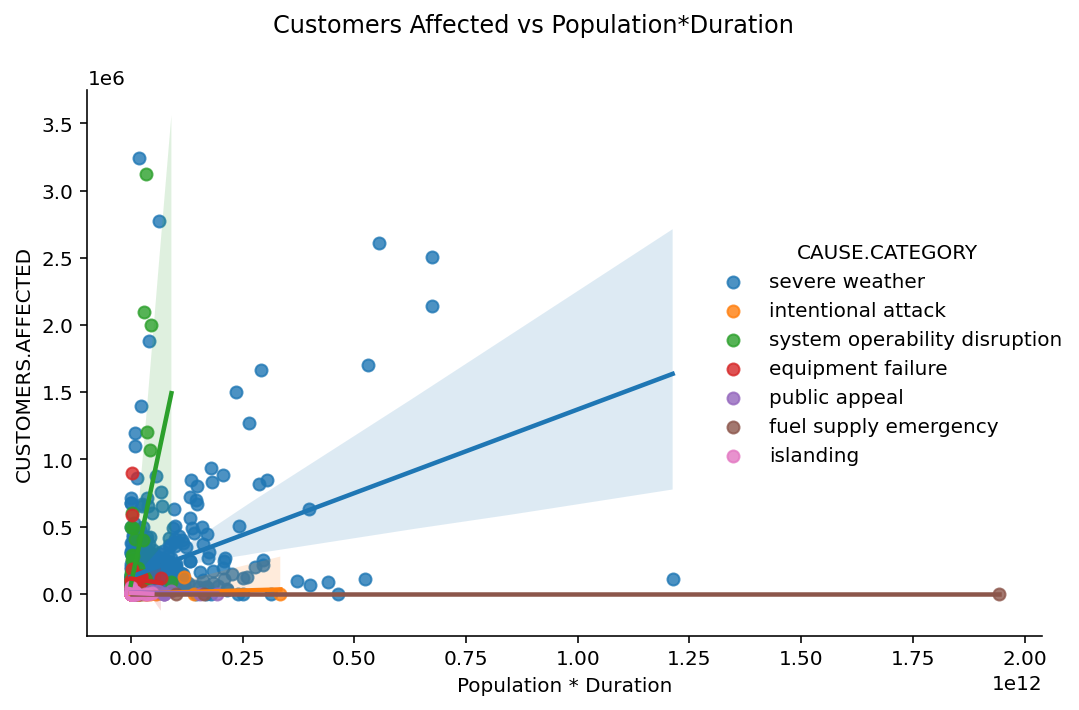

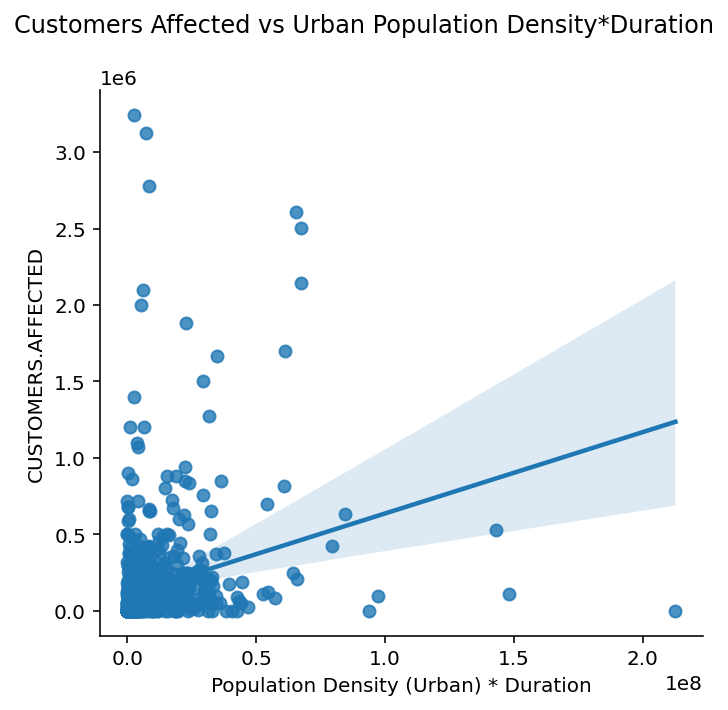

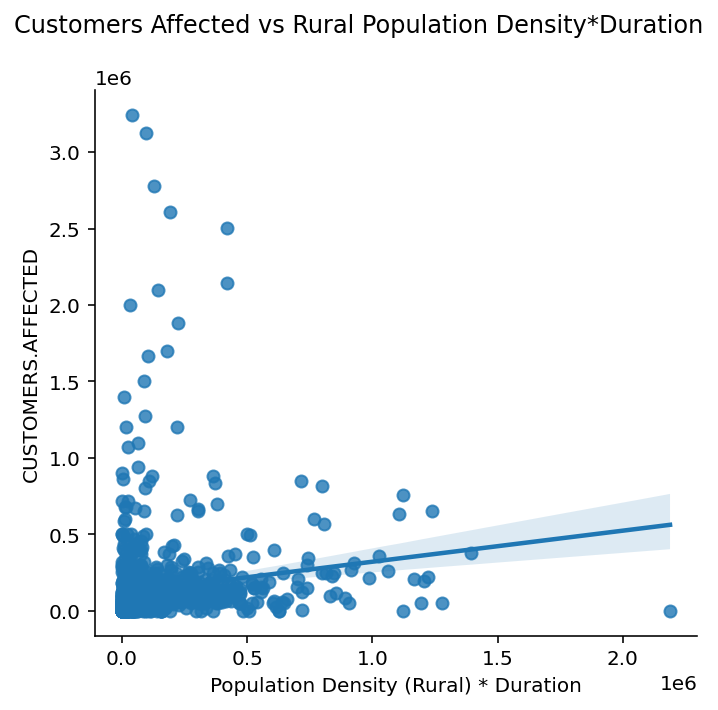

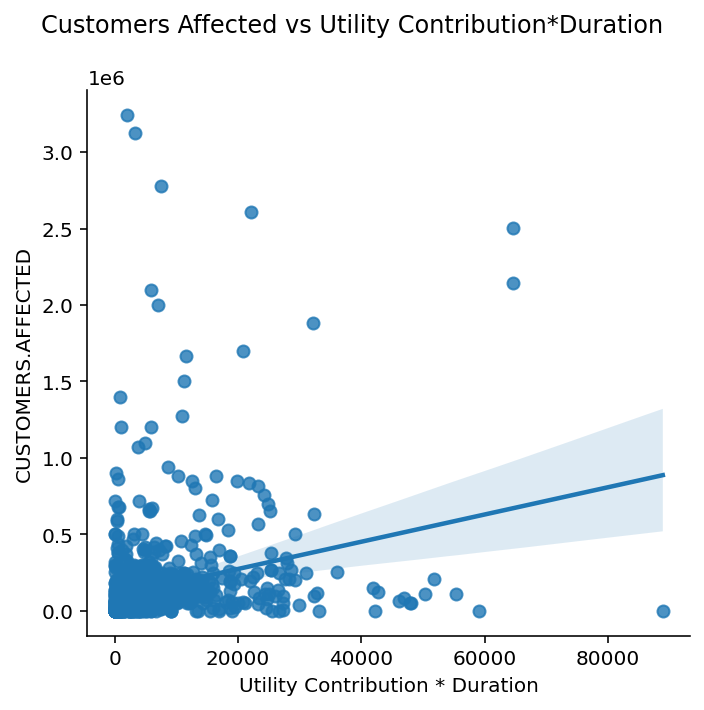

In [633]:
# perhaps we want to consider interaction between features
df_test = df.copy()

# let's consider the marginal effect of population AND outage duration on the number of customers affected
df_test['inter_pop_duration'] = df['POPULATION']*df['OUTAGE.DURATION']

# let's consider the marginal effect of total customers (which we assume that we won't know when the power outage takes place) 
# AND outage duration on the number of customers affected
df_test['inter_cus_duration'] = df['TOTAL.CUSTOMERS']*df['OUTAGE.DURATION']

# let's consider the marginal effect of population density in urban areas AND outage duration on the number of customers affected
df_test['inter_popden_duration'] = df['POPDEN_URBAN']*df['OUTAGE.DURATION']

# let's consider the marginal effect of population density in rural areas AND outage duration on the number of customers affected
df_test['inter_popden_rural_duration'] = df['POPDEN_RURAL']*df['OUTAGE.DURATION']

# let's consider the marginal effect of utility contribution AND outage duration on the number of customers affected
df_test['inter_util_duration'] = df['UTIL.CONTRI']*df['OUTAGE.DURATION']

# plotting all interaction features
sns.lmplot(data=df_test, x='inter_cus_duration', y='CUSTOMERS.AFFECTED').fig.suptitle("Customers Affected vs Total Customer*Duration")
plt.xlabel('Total Customer * Duration')
plt.tight_layout()

sns.lmplot(data=df_test, x='inter_pop_duration', y='CUSTOMERS.AFFECTED', hue='CAUSE.CATEGORY').fig.suptitle("Customers Affected vs Population*Duration")
plt.xlabel('Population * Duration')
plt.tight_layout()

sns.lmplot(data=df_test, x='inter_popden_duration', y='CUSTOMERS.AFFECTED').fig.suptitle("Customers Affected vs Urban Population Density*Duration")
plt.xlabel('Population Density (Urban) * Duration')
plt.tight_layout()

sns.lmplot(data=df_test, x='inter_popden_rural_duration', y='CUSTOMERS.AFFECTED').fig.suptitle("Customers Affected vs Rural Population Density*Duration")
plt.xlabel('Population Density (Rural) * Duration')
plt.tight_layout()

sns.lmplot(data=df_test, x='inter_util_duration', y='CUSTOMERS.AFFECTED').fig.suptitle("Customers Affected vs Utility Contribution*Duration")
plt.xlabel('Utility Contribution * Duration')
plt.tight_layout()

plt.show()

It seems like there's a much obvious relationship between the number of customers affected and interaction terms, especially for **total customers * duration, urban population density * duration, and utility contribution * duration**

**In reality, it is unlikely that we will have the number of total customers in a state immediately after a power outage** - considering a state has many electricity providers and the number of total customers is only computed by the end of the (fiscal) year.

Furthermore, in our dataset, we may not necessarily have the past year total customers to refer to as major power outages do not take place every single year. For example, in Alabama, power outages happened in year 2000, 2013, 2014, and 2015.

**Logically, the number of customers depends on population - the greater the population, the more the people (customers) using electricity.** 

**Let's see if there is any correlation between population and total customers**

Text(0.5, 0.98, 'Total Customers vs Population')

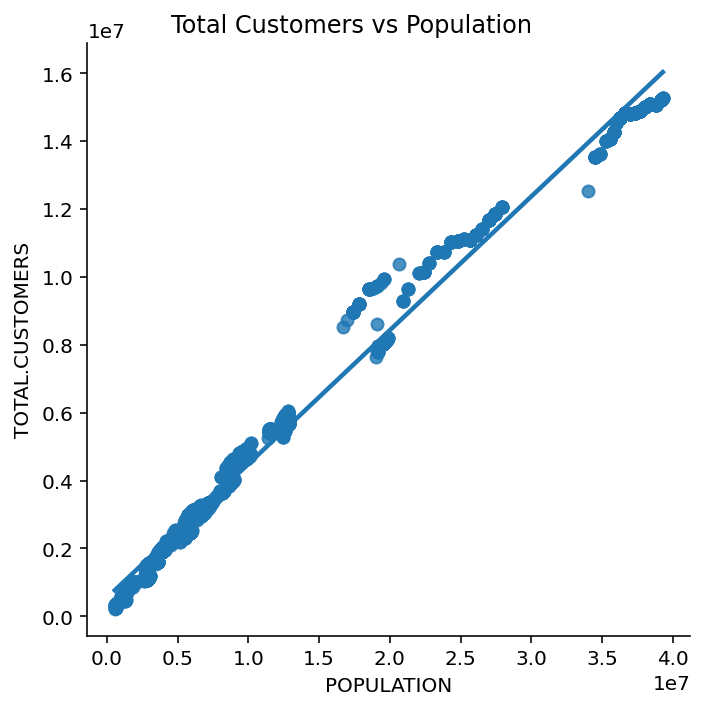

In [425]:
# check relationship between population and total customers
sns.lmplot(data=df, x='POPULATION', y='TOTAL.CUSTOMERS').fig.suptitle('Total Customers vs Population')

GREAT! There is a strong correlation between total customers and population (which is sort of expected). We can now create a separate linear regression function to transform our population data.

In [542]:
# function to predict number of customers
def pred_customer_create_interaction(data):
    df_pop_customer = df[['POPULATION', 'TOTAL.CUSTOMERS']].dropna()
    X = df_pop_customer[['POPULATION']]
    y = df_pop_customer['TOTAL.CUSTOMERS']
    lr = LinearRegression()
    lr.fit(X, y)
    pred = lr.predict(data[['POPULATION']])
    return pd.DataFrame(pred*data.iloc[:,-1])

# function to create interaction terms
def create_interaction_two(df):
    return pd.DataFrame(df.iloc[:,0]*df.iloc[:,1])

#### Linear Regression Model

In [592]:
# get the columns that we need
df_final = df[['OUTAGE.DURATION', 'U.S._STATE','NERC.REGION', 'CLIMATE.REGION', 'POPULATION', 'CUSTOMERS.AFFECTED', 'CAUSE.CATEGORY', 'POPDEN_URBAN']].dropna()
X_final = df_final[['OUTAGE.DURATION', 'U.S._STATE','NERC.REGION', 'CLIMATE.REGION', 'POPULATION', 'CAUSE.CATEGORY', 'POPDEN_URBAN']]
y_final = np.sqrt(df_final['CUSTOMERS.AFFECTED']) #take squareroot of customers affected

# Split our dataset into training and testing data
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X_final, y_final, test_size=0.2)

# Column Transformer 
final_feature_eng = ColumnTransformer([
    ('ohe', Pipeline([('ohe', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))]), \
     ['U.S._STATE', 'NERC.REGION', 'CLIMATE.REGION','CAUSE.CATEGORY']),
    ('ft_pred_pop', Pipeline([('ft', FunctionTransformer(pred_customer_create_interaction))]), \
     ['POPULATION', 'OUTAGE.DURATION']),
    ('ft_popden_du', Pipeline([('ft', FunctionTransformer(create_interaction_two))]), ['POPDEN_URBAN', 'OUTAGE.DURATION']),
    ('original', Pipeline([('ft', FunctionTransformer(lambda x: x))]), ['OUTAGE.DURATION'])
], remainder='passthrough')

# Pipeline with Linear Regression
lr_pl_final = Pipeline([
    ('feature', final_feature_eng),
    ('lin_reg', LinearRegression())
])

# perform KFold cross validation to check R2 and RMSE of our validation test
folds = KFold(n_splits = 5, shuffle=True) # shuffle before doing cross validation
lr_r2_val_scores = cross_val_score(lr_pl_final, X_final_train, y_final_train, scoring='r2', cv=folds)
lr_rmse_val_scores = -1*cross_val_score(lr_pl_final, X_final_train, y_final_train, scoring='neg_root_mean_squared_error', cv=folds)
print('Mean R2 of CV: ', lr_r2_val_scores.mean())
print('Mean RMSE of CV: ', lr_rmse_val_scores.mean())

Mean R2 of CV:  0.3576897076255309
Mean RMSE of CV:  203.33341459810666


In [593]:
# now, let's fit our model
lr_pl_final.fit(X_final_train, y_final_train)

# here, we will compute the R2 for both the testing data and training data (as a whole)
print('R2 of Test Data: ', lr_pl_final.score(X_final_test, y_final_test))
print('R2 of Training Data: ', lr_pl_final.score(X_final_train, y_final_train))

R2 of Test Data:  0.36516367438261055
R2 of Training Data:  0.45074155405585237


Compared to our baseline model, our final linear regression model has largely improved in terms of R2

#### Ridge Regression Model

In [594]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Ridge Regression Pipeline, fit and transform training data
ridge_pl_final = Pipeline([
    ('feature', final_feature_eng)
])
X_final_train_fit = ridge_pl_final.fit_transform(X_final_train, y_final_train)
X_final_test_fit = ridge_pl_final.transform(X_final_test)

# perform GridSearch to find the best alpha parameter
folds = KFold(n_splits = 5, shuffle=True)
hyperparam = dict(alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000])
r = Ridge()
ridge_grid = GridSearchCV(r, hyperparam, cv=folds, scoring='r2')
ridge_grid = ridge_grid.fit(X_final_train_fit, y_final_train)
print('Best R2 of CV: ', ridge_grid.best_score_)
print('Best alpha for Ridge: ', ridge_grid.best_params_)

print('R2 of Test Data: ', ridge_grid.score(X_final_test_fit, y_final_test))
print('R2 of Training Data: ', ridge_grid.score(X_final_train_fit, y_final_train))

Best R2 of CV:  0.3690976962813091
Best alpha for Ridge:  {'alpha': 10}
R2 of Test Data:  0.33896868902762844
R2 of Training Data:  0.43563986587464776


Ridge regression also returns better R2 values compared to our baseline model, though its R2 values are slightly lower than the final linear regression model

#### SGDRegressor

In [595]:
from sklearn.linear_model import SGDRegressor

# Fit and transform training data
SGD_pl_final = Pipeline([
    ('feature', final_feature_eng)
])
X_final_train_fit = SGD_pl_final.fit_transform(X_final_train, y_final_train)
X_final_test_fit = SGD_pl_final.transform(X_final_test)

# perform GridSearch to find the best alpha parameter
folds = KFold(n_splits = 5, shuffle=True)
hyperparam = {'loss': ['squared_error', 'huber']}
sgd = SGDRegressor()
sgd_grid = GridSearchCV(sgd, hyperparam, cv=folds)
sgd_grid = sgd_grid.fit(X_final_train_fit, y_final_train)
print('Best R2 of CV: ', sgd_grid.best_score_)
print('Best alpha for SGD: ', sgd_grid.best_params_)

print('R2 of Test Data: ', sgd_grid.score(X_final_test_fit, y_final_test))
print('R2 of Training Data: ', sgd_grid.score(X_final_train_fit, y_final_train))

Best R2 of CV:  -1.0383837391859333e+29
Best alpha for SGD:  {'loss': 'huber'}
R2 of Test Data:  -3.416436480669494e+26
R2 of Training Data:  -1.246812784531349e+26


SGD Regressor performs worse than our baseline model

Conclusion: We will choose linear regression model as our final model given that it has the highest R2 value for our validation data, test data and training data.

### Fairness Analysis

In [610]:
# get dataset and run prediction for fairness analysis
df_fair = df[['OUTAGE.DURATION', 'U.S._STATE','NERC.REGION', 'CLIMATE.REGION', \
              'POPULATION', 'CUSTOMERS.AFFECTED', 'CAUSE.CATEGORY', 'POPDEN_URBAN']].dropna()
df_fair['PREDICTED_CUSTOMERS.AFFECTED'] = lr_pl_final.predict(
    df_fair[['OUTAGE.DURATION', 'U.S._STATE','NERC.REGION', 'CLIMATE.REGION', 'POPULATION', 'CAUSE.CATEGORY', 'POPDEN_URBAN']])**2

# categorize by high population state (>10mil population) and mid-low population state (<10mil population)
df_fair['POPULATED'] = np.where(df_fair['POPULATION'] >= 10_000_000, 'high', 'mid-low')
df_fair['POPULATED'].value_counts(normalize=True)

mid-low    0.558516
high       0.441484
Name: POPULATED, dtype: float64

We manually created two groups - highly populated states and mid-low population states. In our dataset, roughly 44% observations were in highly populated states while 55% in states with mid-low population.

Now, our dataset is ready for permutation test. Let's first get our observed R2.

In [613]:
# we define a formula for R2 = var(predicted y-values)/var(actual y-values)
def r2(pred, actual):
    return np.var(pred)/np.var(actual)

In [629]:
df_test = df_fair[['POPULATED', 'PREDICTED_CUSTOMERS.AFFECTED', 'CUSTOMERS.AFFECTED']]
obs = df_test.groupby('POPULATED').apply(lambda x: r2(x['PREDICTED_CUSTOMERS.AFFECTED'], x['CUSTOMERS.AFFECTED'])).diff().iloc[-1]
obs

0.09696247862257583

Null Hypothesis: Our final linear regression model is fair - R2 values for states with high population and mid-low population are roughly the same, and any differences are due to random chance.

Alternative Hypothesis: Our model is unfair - R2 for highly populated states is lower than mid-low population states.

We will run the permutation test at 99% confidence level

0.078

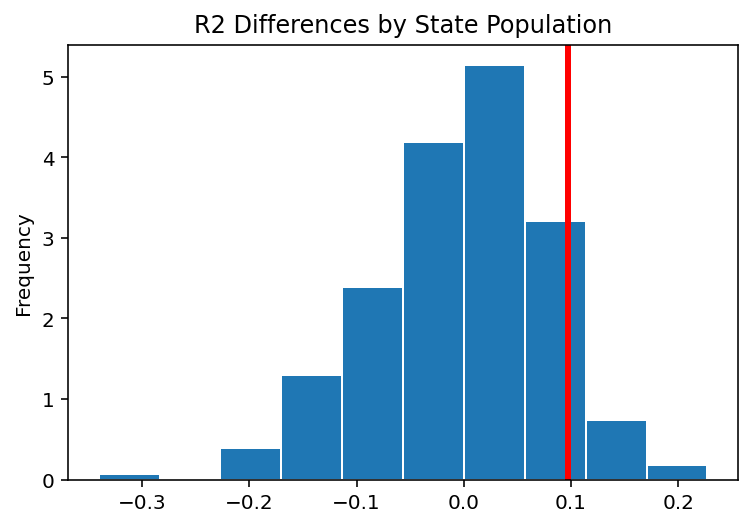

In [631]:
# run simulations for 500 times
diff_r2 = []
for i in range(500):
    df_test['POPULATED'] = np.random.permutation(df_test['POPULATED'])
    t = df_test.groupby('POPULATED').apply(lambda x: r2(x['PREDICTED_CUSTOMERS.AFFECTED'], x['CUSTOMERS.AFFECTED'])).diff().iloc[-1]
    diff_r2.append(t)

# visualize our test statistics and observed statistic
title = 'R2 Differences by State Population'
pd.Series(diff_r2).plot(kind='hist', density=True, ec='w', title=title)
plt.axvline(x=obs, color='red', linewidth=3);

# p-value
(diff_r2 >= obs).mean()

Conclusion: Since our p-value is greater than 0.01, we will not reject the null hypothesis. There is insufficient evidence to conclude that our model is unfair.